In [2]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)


In [3]:
import sys
import glob, os

# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [4]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use('default')
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import cross_val_score

In [6]:

from tensorflow import keras
import keras_tuner as kt
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np

In [7]:
import random
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [8]:
from tabpfn import TabPFNClassifier as tbp
import shapiq

In [9]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Load Data
Here we will load the data from IU and CU (Piccirillo)

In [169]:
dataset = pd.read_csv(here() / config.data_interim / 'd_p_h_combined_unnormalized.csv')
dataset

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,Day 1 CD34 Absolute per uL,Count,lab
0,1,39,11.2,14.6,43.5,328.0,64.5,2.9,7.4,25.5,1.9,0.8,7.2,0.2,100.0,1,Dipersio
1,0,57,6.5,14.5,42.9,280.0,48.1,2.7,5.9,41.1,4.0,0.4,3.1,0.3,71.0,1,Dipersio
2,1,43,4.4,15.0,43.9,299.0,58.0,1.3,10.0,28.7,2.7,0.4,2.6,0.1,87.0,1,Dipersio
3,0,50,6.7,14.2,40.6,243.0,56.4,2.0,7.7,29.8,4.8,0.5,3.8,0.3,27.0,0,Dipersio
4,0,32,9.8,13.3,39.2,373.0,65.1,2.6,6.4,26.5,1.7,0.6,6.4,0.2,31.0,0,Dipersio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,1,23,31.3,13.5,39.4,257.0,76.0,2.8,8.0,9.0,1.0,2.5,23.8,0.3,58.0,1,hurwitz
1156,1,56,37.0,15.4,44.9,233.0,77.0,4.4,7.0,12.0,1.0,2.6,28.5,0.4,59.0,1,hurwitz
1157,0,25,51.9,13.8,40.7,265.0,64.0,7.3,9.0,14.0,1.0,4.7,33.2,0.5,56.0,1,hurwitz
1158,1,22,51.0,14.6,42.9,250.0,89.0,4.1,2.0,8.0,1.0,1.0,45.3,0.5,174.0,1,hurwitz


In [170]:
# add labtype column and set it to 0 if lab is 'Dipersio' else 1
dataset['labtype'] = dataset['lab'].apply(lambda x: 0 if x == 'Dipersio' else 1)
dataset = dataset.drop(columns=['lab'])

# move labtype to the 3rd column
cols = dataset.columns.tolist()
cols.insert(2, cols.pop(cols.index('labtype')))
dataset = dataset[cols]


In [171]:
dataset.drop(columns=['Day 1 CD34 Absolute per uL'], inplace=True)

In [172]:
# apply linear normalization
df_temp = dataset.iloc[:,:-1]
dataset.iloc[:,:-1] = (df_temp - df_temp.min()) / (df_temp.max() - df_temp.min())

In [173]:
# oversample the bad mobilizers to balance the dataset with SMOTE
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)


In [174]:
# convert y in to binary classes
y = (y > 0).astype(int)

In [175]:
df = dataset.copy()

In [176]:

FEATURES    = df.columns.difference(['Count'])   # all but target
NUMERICS    = FEATURES.difference(['labtype']) # all numeric features

# X_full      = df[FEATURES].copy()
# y_full      = df['Count'].values
X_full = X.copy()
y_full = y.values

# perform train-test split
# 80% train, 20% test, then 80% train, 20% validation
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X_full, y_full, test_size=0.20, random_state=RANDOM_STATE, stratify=y_full)

X_val, X_test, y_val, y_test   = train_test_split(
    X_tmp,  y_tmp,  test_size=0.20, random_state=RANDOM_STATE, stratify=y_tmp)

In [ ]:
# scaler = StandardScaler()
# X_train[NUMERICS] = scaler.fit_transform(X_train[NUMERICS])
# X_val[NUMERICS]   = scaler.transform(X_val[NUMERICS])
# X_test[NUMERICS]  = scaler.transform(X_test[NUMERICS])

# # SMOTE on *training* fold only     #
# smote = SMOTE(random_state=RANDOM_STATE)
# X_tr_over, y_tr_over = smote.fit_resample(X_train, y_train)
# print(pd.Series(y_tr_over).value_counts())


In [177]:
X_tr_over = X_train.copy()
y_tr_over = y_train.copy()

In [178]:
# # #########################################
# # the model works fine with               
# # Precision: 0.76
# # Recall: 0.86
# # F1 Score: 0.81
# # Accuracy: 0.80
# # AUC: 0.89
# # learning rate = 0.001
# # epochs = 250
# # batch_size = 128
# # good learning curve too
# # model saved as 'cbc_domain_attention_aware'
# # ###################################################################################
# # Building a custom attention layer for feature-wise attention modulated by labtype #
# # ###################################################################################

n_feat = len(NUMERICS)  # numeric  + age + gender   (excl. labtype)

# ── Inputs ──────────────────────────────────────────────────────────────
feat_in = layers.Input(shape=(n_feat,),   name='features')   # tensor A
lab_in  = layers.Input(shape=(1,),        name='labtype')    # tensor B

# ── Custom feature-wise attention modulated by labtype ──────────────────
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

att_layer             = FeatureAttention(n_feat)
att_out, att_weights  = att_layer([feat_in, lab_in])

# ── Down-stream classifier ──────────────────────────────────────────────
x = layers.Dense(264, activation='leaky_relu', 
                 kernel_initializer='normal',
                 kernel_regularizer = regularizers.l2(0.02)
                 )(att_out)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu', 
                 kernel_initializer='normal', 
                 kernel_regularizer=regularizers.l2(0.02)
                 )(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
logit = layers.Dense(1, activation='sigmoid')(x)

model   = models.Model(inputs=[feat_in, lab_in], outputs=logit, name='CBC_Attn_CLF')
att_extractor = models.Model(inputs=[feat_in, lab_in], outputs=att_weights)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='acc')])

model.summary()

Model: "CBC_Attn_CLF"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labtype             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_… │ [(None, 14),      │        434 │ features[0][0],   │
│ (FeatureAttention)  │ (None, 14)]       │            │ labtype[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 264)       │      3,960 │ feature_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 264)       │          0 │ dense_104[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 264)       │      1,056 │ dropout_56[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_105 (Dense)   │ (None, 128)       │     33,920 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_57          │ (None, 128)       │          0 │ dense_105[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_106 (Dense)   │ (None, 64)        │      8,256 │ dropout_57[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 64)        │          0 │ dense_106[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_107 (Dense)   │ (None, 4)         │        260 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 4)         │          0 │ dense_107[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_108 (Dense)   │ (None, 1)         │          5 │ dropout_59[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,891 (187.07 KB)

 Trainable params: 47,363 (185.01 KB)

 Non-trainable params: 528 (2.06 KB)

In [101]:

n_feat = len(NUMERICS)  # numeric  + age + gender   (excl. labtype)

# ── Inputs ──────────────────────────────────────────────────────────────
feat_in = layers.Input(shape=(n_feat,),   name='features')   # tensor A
lab_in  = layers.Input(shape=(1,),        name='labtype')    # tensor B

# ── Custom feature-wise attention modulated by labtype ──────────────────
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

att_layer             = FeatureAttention(n_feat)
att_out, att_weights  = att_layer([feat_in, lab_in])

# ── Down-stream classifier ──────────────────────────────────────────────
x = layers.Dense(264, activation='leaky_relu', 
                 kernel_initializer='normal',
                 kernel_regularizer = regularizers.l2(0.01)
                 )(att_out)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu', 
                 kernel_initializer='normal', 
                 kernel_regularizer=regularizers.l2(0.01)
                 )(x)
# x = layers.BatchNormalization()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='relu')(x)
x = layers.Dropout(0.2)(x)
logit = layers.Dense(1, activation='sigmoid')(x)

model   = models.Model(inputs=[feat_in, lab_in], outputs=logit, name='CBC_Attn_CLF')
att_extractor = models.Model(inputs=[feat_in, lab_in], outputs=att_weights)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.BinaryAccuracy(name='acc')])

model.summary()

Model: "CBC_Attn_CLF"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features            │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labtype             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_attention_8 │ [(None, 14),      │        434 │ features[0][0],   │
│ (FeatureAttention)  │ (None, 14)]       │            │ labtype[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 264)       │      3,960 │ feature_attentio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 264)       │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 264)       │      1,056 │ dropout_20[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 128)       │     33,920 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 64)        │      8,256 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 64)        │          0 │ dense_45[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_46 (Dense)    │ (None, 4)         │        260 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 4)         │          0 │ dense_46[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 1)         │          5 │ dropout_23[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,891 (187.07 KB)

 Trainable params: 47,363 (185.01 KB)

 Non-trainable params: 528 (2.06 KB)

In [179]:
# preparing numpy matric
def split_xy(frame):
    f = frame.drop(columns=['labtype']).values.astype(np.float32)
    l = frame[['labtype']].values.astype(np.float32)
    return f, l

X_tr_f, X_tr_lab = split_xy(X_tr_over)
X_v_f,  X_v_lab  = split_xy(X_val)
X_te_f, X_te_lab = split_xy(X_test)


In [180]:
# train the network
# es = callbacks.EarlyStopping(monitor='val_auc', mode='max',
#                              patience=10, restore_best_weights=True)

hist = model.fit([X_tr_f, X_tr_lab], y_tr_over,
                 validation_data=([X_v_f, X_v_lab], y_val),
                 epochs=250, batch_size=128,
                #  callbacks=[es],
                 verbose=2)


Epoch 1/250
12/12 - 2s - 168ms/step - acc: 0.5115 - auc: 0.5441 - loss: 2.2832 - val_acc: 0.5000 - val_auc: 0.5270 - val_loss: 1.9643
Epoch 2/250
12/12 - 0s - 9ms/step - acc: 0.5602 - auc: 0.5752 - loss: 1.7584 - val_acc: 0.5338 - val_auc: 0.5286 - val_loss: 1.5419
Epoch 3/250
12/12 - 0s - 9ms/step - acc: 0.5697 - auc: 0.5911 - loss: 1.3990 - val_acc: 0.5000 - val_auc: 0.5459 - val_loss: 1.2591
Epoch 4/250
12/12 - 0s - 9ms/step - acc: 0.5670 - auc: 0.5936 - loss: 1.1611 - val_acc: 0.5000 - val_auc: 0.5826 - val_loss: 1.0721
Epoch 5/250
12/12 - 0s - 9ms/step - acc: 0.5771 - auc: 0.6025 - loss: 1.0009 - val_acc: 0.5000 - val_auc: 0.5880 - val_loss: 0.9490
Epoch 6/250
12/12 - 0s - 9ms/step - acc: 0.5913 - auc: 0.6151 - loss: 0.8951 - val_acc: 0.5000 - val_auc: 0.5984 - val_loss: 0.8674
Epoch 7/250
12/12 - 0s - 9ms/step - acc: 0.5873 - auc: 0.6079 - loss: 0.8261 - val_acc: 0.5743 - val_auc: 0.5946 - val_loss: 0.8123
Epoch 8/250
12/12 - 0s - 9ms/step - acc: 0.5873 - auc: 0.6104 - loss: 0.77

In [54]:
import keras


In [ ]:
class FeatureAttention(layers.Layer):
    def __init__(self, units, **kw):
        super().__init__(**kw)
        self.hid  = layers.Dense(units, activation='tanh')  # hidden layer
        self.alpha = layers.Dense(units, activation='softmax')  # attention weights

    def call(self, inputs):
        feats, lab = inputs
        x = tf.concat([feats, lab], axis=-1)      # (batch, units+1)
        e = self.hid(x)
        a = self.alpha(e)                         # (batch, units)  row-softmax
        return feats * a, a                       # return both for later

model = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_aware_2.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [ ]:

model = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_aware_2.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [181]:
######################################################
# Evaluate – metrics & ROC curve on hold-out set #
######################################################
y_prob = model.predict([X_te_f, X_te_lab]).ravel()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred, digits=3))

# fpr, tpr, _ = roc_curve(y_test, y_prob)
# roc_auc      = auc(fpr, tpr)

# plt.figure()
# # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.3f})')
# plt.plot([0, 1], [0, 1], linestyle='--')
# plt.xlabel('False Positive Rate');  plt.ylabel('True Positive Rate')
# plt.title('CBC Mobilizer Classifier – ROC Curve')
# plt.legend(loc='lower right')
# plt.show()




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

           0      0.780     0.865     0.821        37
           1      0.848     0.757     0.800        37

    accuracy                          0.811        74
   macro avg      0.814     0.811     0.810        74
weighted avg      0.814     0.811     0.810        74



In [215]:
att_test = att_extractor.predict([X_te_f, X_te_lab])
att_df   = pd.DataFrame(att_test, columns=X_train.drop(columns=['labtype']).columns)
att_df['labtype'] = X_test['labtype'].values

# add 0.5 to the attention weights lesser than 0.5 and save the attention weights as differennt df
# attention_df = att_df.iloc[:,:-1]
# attention_df[attention_df < 0.5] += 0.05
# attention_df['labtype'] = att_df['labtype'].values
attention_df = att_df.iloc[:,:-1]
# add a very small value to the attention weights lesser than 0.05
attention_df[attention_df < 0.05] += 0.05
attention_df['labtype'] = att_df['labtype'].values


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [216]:
attention_df

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,labtype
0,0.244744,0.158896,0.103815,0.060219,0.052549,0.080725,0.305613,0.071371,0.058473,0.093922,0.053494,0.054329,0.057592,0.054259,0.0
1,0.099989,0.063834,0.242606,0.056660,0.052000,0.234655,0.327688,0.087496,0.052761,0.059652,0.052593,0.060275,0.058078,0.051714,1.0
2,0.258794,0.054039,0.262050,0.055483,0.051295,0.112471,0.305467,0.077368,0.053757,0.058340,0.051236,0.054680,0.053494,0.051528,1.0
3,0.097474,0.224854,0.067451,0.059002,0.052857,0.334751,0.216313,0.079307,0.055411,0.081946,0.055253,0.060384,0.061534,0.053462,0.0
4,0.084937,0.101167,0.089716,0.063005,0.052850,0.365731,0.224349,0.083833,0.058627,0.091483,0.055070,0.063479,0.061264,0.054489,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.153034,0.269462,0.083482,0.058729,0.052498,0.110832,0.291976,0.068701,0.055888,0.086823,0.053391,0.053957,0.057738,0.053489,0.0
70,0.260326,0.066759,0.189409,0.054170,0.051342,0.092026,0.447414,0.067290,0.052963,0.059604,0.051243,0.052317,0.053605,0.051531,1.0
71,0.196379,0.175421,0.090676,0.059482,0.051967,0.151248,0.298636,0.068093,0.055777,0.086801,0.052714,0.053711,0.056098,0.052997,0.0
72,0.286029,0.106816,0.110398,0.063457,0.052404,0.127397,0.257208,0.070886,0.058548,0.096681,0.053122,0.055392,0.057370,0.054292,0.0


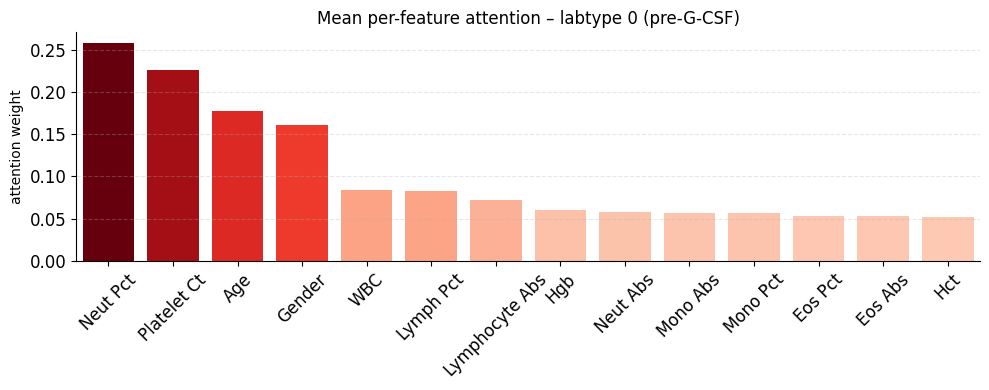

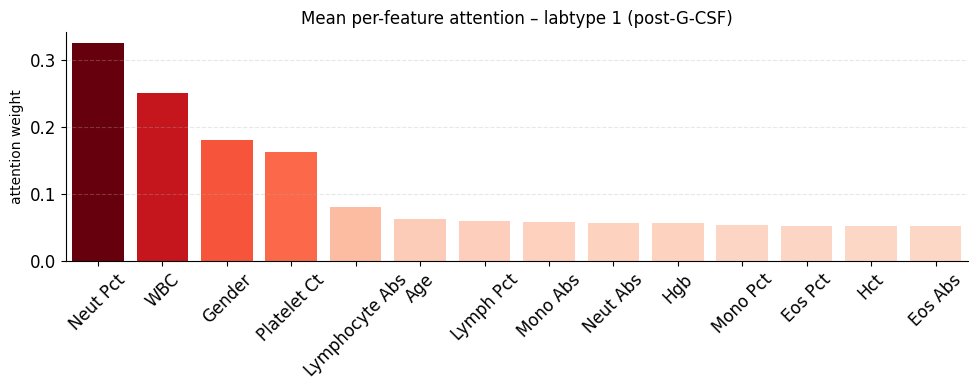

In [218]:
for lt in (0,1):
    mean_w = attention_df[attention_df.labtype==lt].drop(columns=['labtype']).mean()
    ax = plt.figure(figsize=(10,4))
    # sort the mean weights for better visualization
    mean_w = mean_w.sort_values(ascending=False)
    mean_w.plot(kind='bar')
    plt.title(f'Mean per-feature attention – labtype {lt} '
              f"({'post' if lt==1 else 'pre'}-G-CSF)")
    plt.ylabel('attention weight')
    # make the axes size thicker for better visibility
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # use gradiend color for bars
    plt.bar(mean_w.index, mean_w.values, color=plt.cm.Reds(mean_w.values / mean_w.max()))
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.png', bbox_inches='tight')
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.pdf', bbox_inches='tight')
    sns.despine()
    plt.tight_layout()
    plt.show()


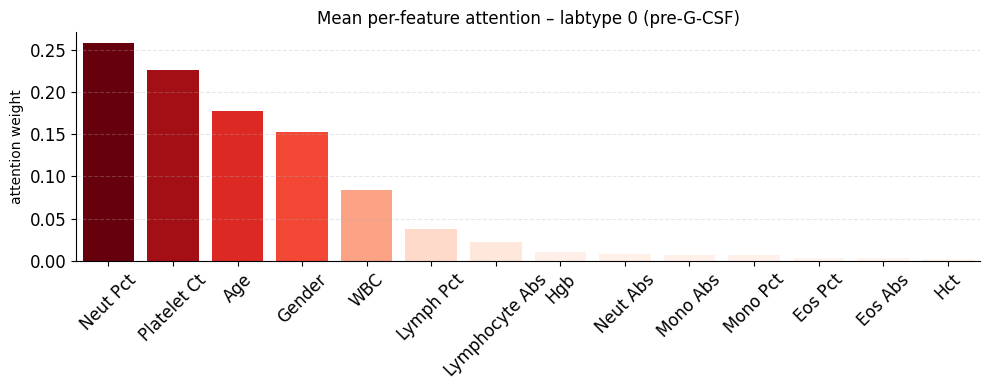

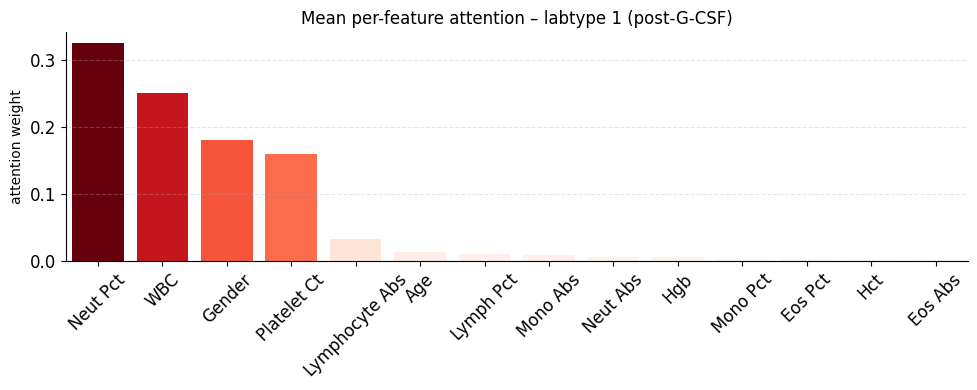

In [214]:
######################################################
# Attention analysis – mean weights per labtype  #
######################################################


for lt in (0,1):
    mean_w = att_df[att_df.labtype==lt].drop(columns=['labtype']).mean()
    ax = plt.figure(figsize=(10,4))
    # sort the mean weights for better visualization
    mean_w = mean_w.sort_values(ascending=False)
    mean_w.plot(kind='bar')
    plt.title(f'Mean per-feature attention – labtype {lt} '
              f"({'post' if lt==1 else 'pre'}-G-CSF)")
    plt.ylabel('attention weight')
    # make the axes size thicker for better visibility
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # use gradiend color for bars
    plt.bar(mean_w.index, mean_w.values, color=plt.cm.Reds(mean_w.values / mean_w.max()))
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.png', bbox_inches='tight')
    plt.savefig(here() / config.plots / 'attention' / f'cbc_attn_mean_weights_labtype_{lt}.pdf', bbox_inches='tight')
    sns.despine()
    plt.tight_layout()
    plt.show()



In [58]:
# # plot loss curves
# plt.figure(figsize=(10, 6))
# plt.plot(hist.history['loss'], label='Training Loss')
# plt.plot(hist.history['val_loss'], label='Validation Loss')
# plt.title('Loss Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # plot accuracy curves and make spines thicker
# plt.figure(figsize=(10, 6))
# plt.plot(hist.history['acc'], label='Training Accuracy')
# plt.plot(hist.history['val_acc'], label='Validation Accuracy')
# plt.title('Accuracy Curves')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.tick_params(axis='both', which='major', labelsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.3)
# sns.despine()
# plt.tight_layout()
# plt.show()

In [184]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, matthews_corrcoef

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
acur = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {acur:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Matthews Correlation Coefficient: {matthews_corrcoef(y_test, y_pred):.2f}")

Precision: 0.85
Recall: 0.76
F1 Score: 0.80
Accuracy: 0.81
AUC: 0.89
Matthews Correlation Coefficient: 0.63


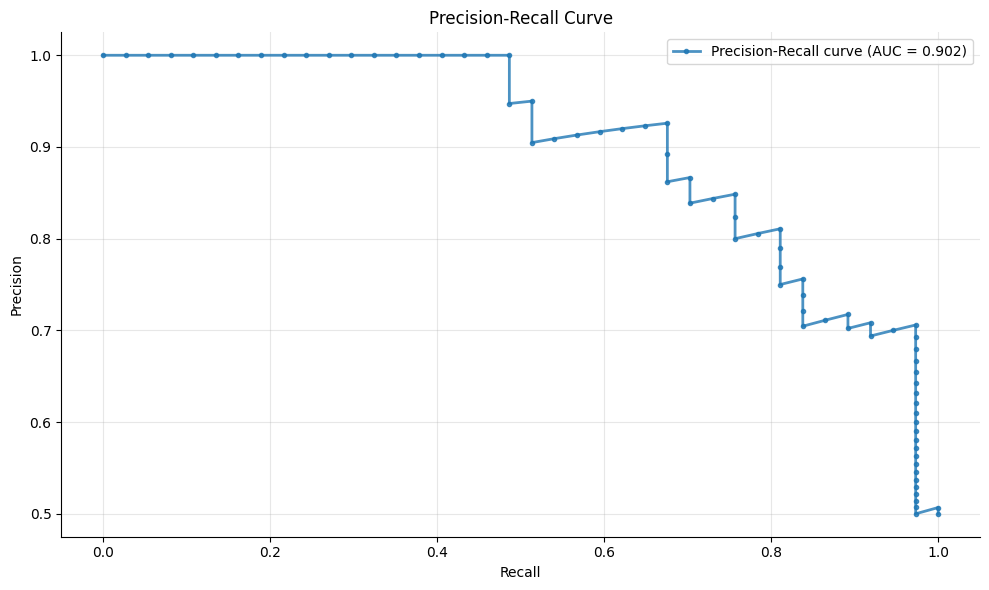

In [263]:

# plot precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
average_precision = average_precision_score(y_test, y_prob)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_score = auc(recall, precision)
plt.figure(figsize=(10, 6))
# smooth the curve by plotting points
# plt.plot(recall, precision, marker='.', label=f'Average Precision: {average_precision:.2f}')

plt.plot(recall, precision, marker = '.', label=f'Precision-Recall curve (AUC = {auc_score:0.3f})',
         linewidth=2, alpha=0.8)

# # Calculate positive class proportion for baseline
# positive_ratio = np.sum(y_test) / len(y_test)
# plt.axhline(y=positive_ratio, color='gray', linestyle='--', alpha=0.7, 
#            label=f'Random baseline ({positive_ratio:.3f})')

# plt.xlim(0, 1)  # Ensure x-axis starts at 0
# plt.ylim(0, 1)  # Ensure y-axis starts at 0
plt.legend(loc='upper right')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_precision_recall_curve.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_precision_recall_curve.pdf',dpi = 300, bbox_inches='tight')
plt.show()

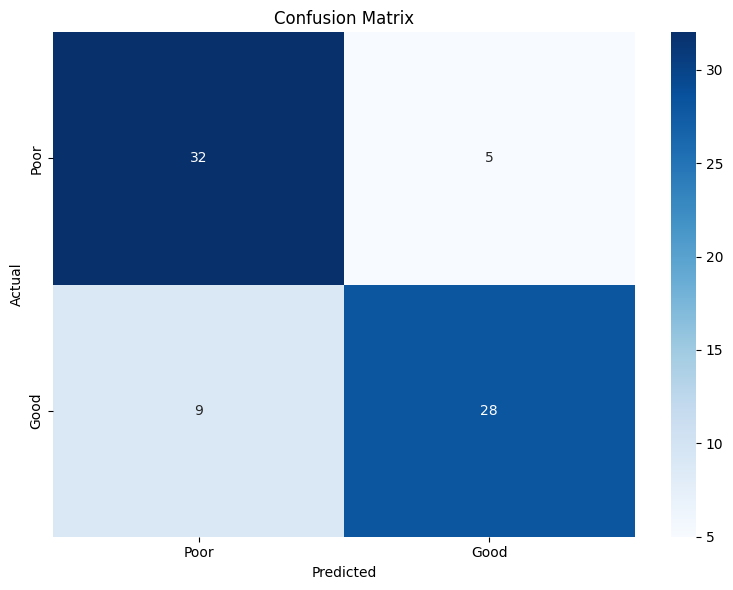

In [191]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar = True, xticklabels=['Poor', 'Good'], yticklabels=['Poor', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_confusion_matrix.pdf', dpi = 300, bbox_inches='tight')
plt.tight_layout()
plt.show()

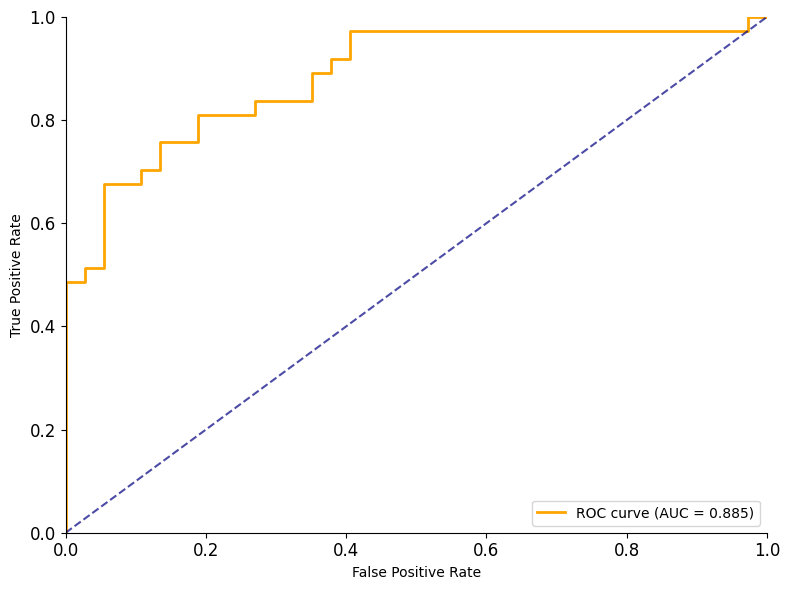

In [231]:
# plot auc curve
fpr, tpr, _ = roc_curve(y_test, y_prob)  # Use y_prob instead of y_pred
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:0.3f})',color = 'orange', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('CBC Mobilizer Classifier – ROC Curve')
plt.legend(loc='lower right')
# plt.grid(alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(0, 1)  # Ensure x-axis starts at 0
plt.ylim(0, 1)  # Ensure y-axis starts at 0
sns.despine()
plt.tight_layout()  
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.png', dpi = 500, bbox_inches='tight')
plt.savefig(here() / config.plots / 'new_models_aa' / 'cbc_roc_curve.pdf', dpi = 300, bbox_inches='tight')
plt.show()

In [31]:
att_extractor = keras.models.load_model(
    here() / config.model_dl / 'cbc_domain_attention_extractor.keras',
    custom_objects={'FeatureAttention': FeatureAttention}
)

In [32]:
att_extractor

<Functional name=functional_2, built=True>

In [ ]:
# save the model 
model.save(here() / config.model_dl / 'attention_aware_final.keras')
# save the attention extractor model
att_extractor.save(here() / config.model_dl /'attention_aware_final.keras')
# save the attention weights
att_df.to_csv(here() / config.model_dl /'attention_aware_final_attnwts.csv', index=False)
# save the training history
hist_df = pd.DataFrame(hist.history)
hist_df.to_csv(here() / config.model_dl / 'attention_aware_final_hist.csv', index=False)
# save the model as pickle
import pickle
with open(here() / config.model_dl / 'attention_aware_final.pkl', 'wb') as f:
    pickle.dump(model, f)
    

In [118]:
cbc_att_wts = pd.read_csv(here() / config.model_dl / 'cbc_domain_attention_weights_xy.csv')

In [119]:
cbc_att_wts

,Gender,Age,WBC,Hgb,Hct,Platelet Ct,Neut Pct,Lymphocyte Abs,Mono Pct,Lymph Pct,Eos Pct,Mono Abs,Neut Abs,Eos Abs,labtype
0,0.182724,0.241969,0.013067,0.008518,0.009902,0.054598,0.168950,0.181704,0.018295,0.025120,0.006717,0.025270,0.048024,0.015141,0.0
1,0.112596,0.171197,0.032517,0.007168,0.012860,0.058243,0.220997,0.103532,0.056134,0.026665,0.010941,0.039427,0.134913,0.012808,1.0
2,0.340266,0.062677,0.007037,0.009918,0.012159,0.064020,0.098179,0.262183,0.017419,0.022434,0.006240,0.025959,0.053030,0.018479,1.0
3,0.070714,0.280157,0.039627,0.008467,0.013957,0.057767,0.186870,0.116195,0.052576,0.030819,0.013699,0.032079,0.082181,0.014892,0.0
4,0.105151,0.135448,0.036744,0.014433,0.016611,0.077332,0.218431,0.154586,0.056118,0.031972,0.017195,0.037671,0.074826,0.023482,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,0.097077,0.436424,0.021905,0.008560,0.012867,0.051870,0.082831,0.124092,0.030492,0.029455,0.009122,0.024653,0.055965,0.014686,0.0
70,0.186316,0.211425,0.007988,0.008703,0.010936,0.035261,0.303507,0.120011,0.011725,0.020098,0.007393,0.017192,0.048620,0.010824,1.0
71,0.132566,0.361362,0.021267,0.007020,0.010139,0.066619,0.069028,0.147990,0.034062,0.027421,0.006125,0.032722,0.069777,0.013900,0.0
72,0.184525,0.233682,0.020881,0.010737,0.012269,0.075462,0.085246,0.185018,0.034512,0.029231,0.007808,0.036214,0.064899,0.019516,0.0


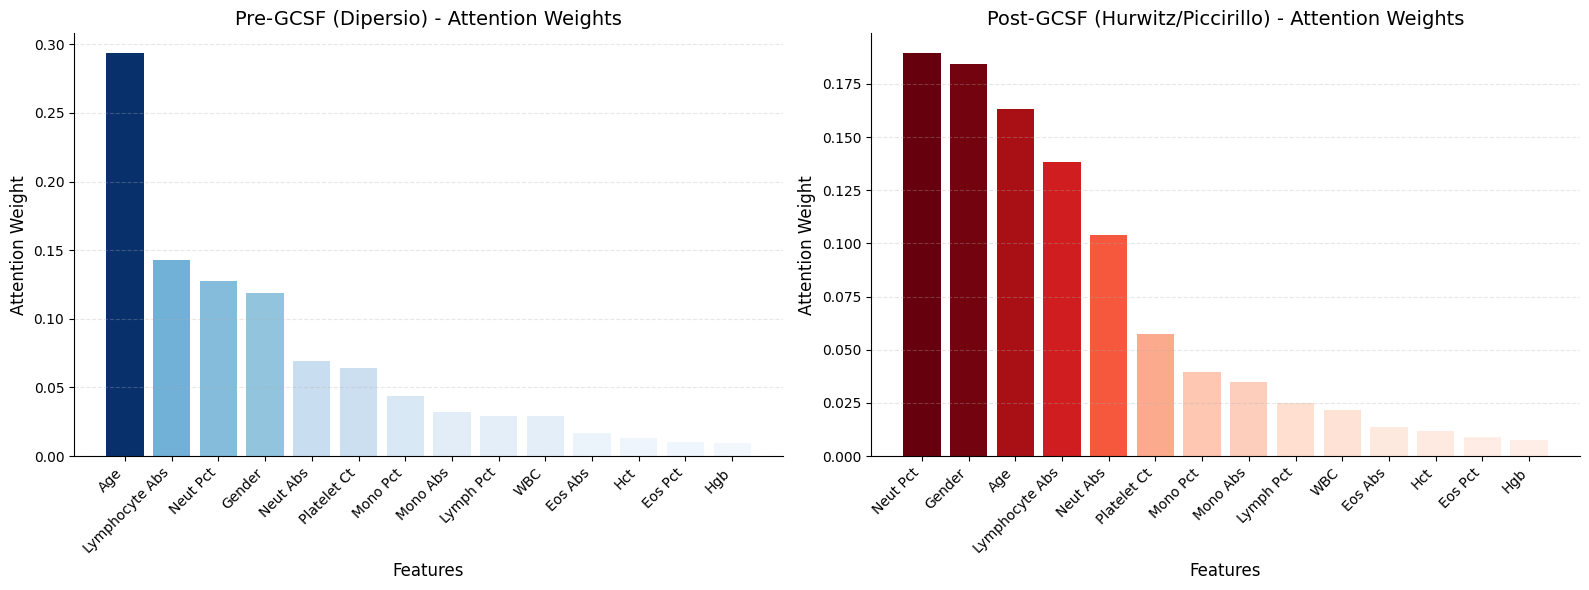

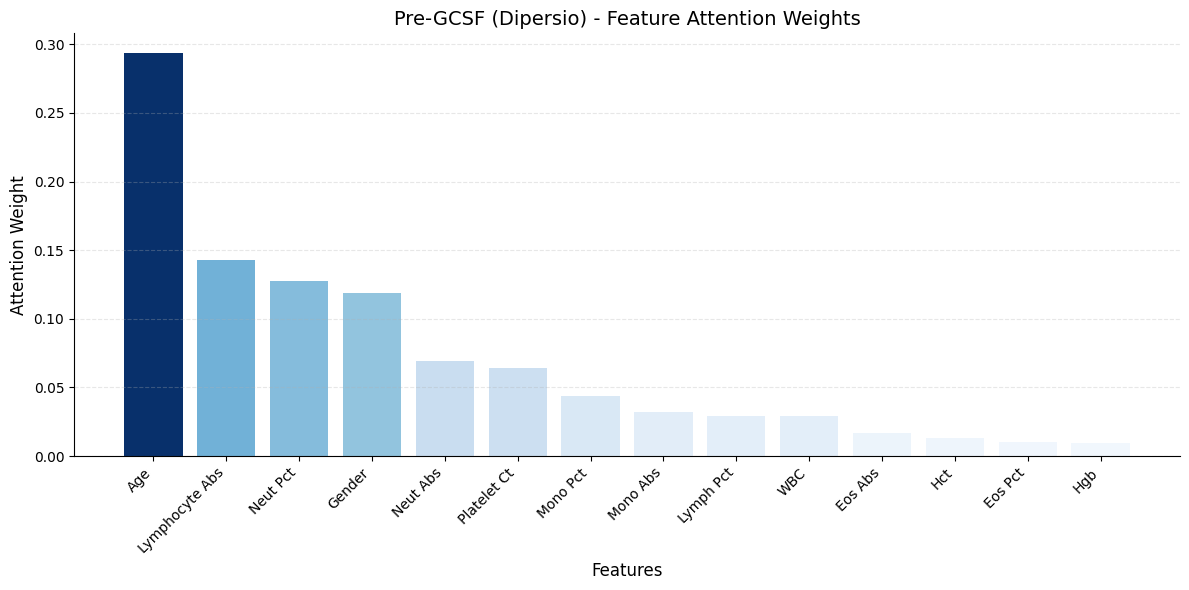

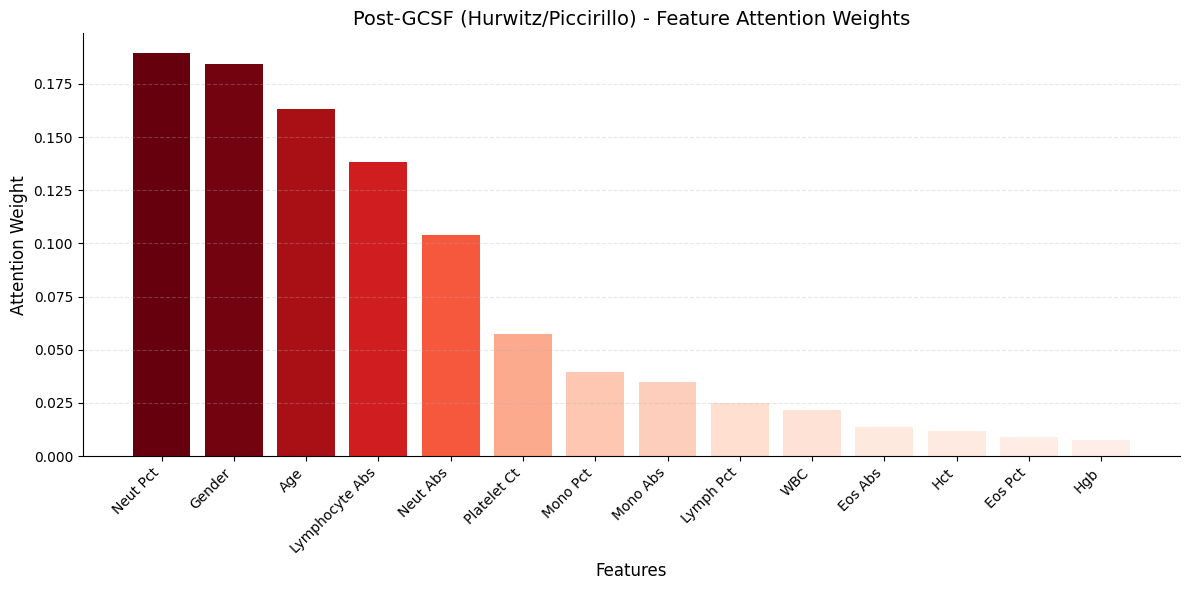

In [120]:
# Plot attention weights for both labtypes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot for labtype 0 (pre-GCSF / Dipersio)
labtype_0 = cbc_att_wts[cbc_att_wts['labtype'] == 0].drop(columns=['labtype']).mean()
labtype_0 = labtype_0.sort_values(ascending=False)

bars1 = ax1.bar(range(len(labtype_0)), labtype_0.values, 
                color=plt.cm.Blues(labtype_0.values / labtype_0.max()))
ax1.set_title('Pre-GCSF (Dipersio) - Attention Weights', fontsize=14)
ax1.set_ylabel('Attention Weight', fontsize=12)
ax1.set_xlabel('Features', fontsize=12)
ax1.set_xticks(range(len(labtype_0)))
ax1.set_xticklabels(labtype_0.index, rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.3)

# Plot for labtype 1 (post-GCSF / Hurwitz/Piccirillo)  
labtype_1 = cbc_att_wts[cbc_att_wts['labtype'] == 1].drop(columns=['labtype']).mean()
labtype_1 = labtype_1.sort_values(ascending=False)

bars2 = ax2.bar(range(len(labtype_1)), labtype_1.values, 
                color=plt.cm.Reds(labtype_1.values / labtype_1.max()))
ax2.set_title('Post-GCSF (Hurwitz/Piccirillo) - Attention Weights', fontsize=14)
ax2.set_ylabel('Attention Weight', fontsize=12)
ax2.set_xlabel('Features', fontsize=12)
ax2.set_xticks(range(len(labtype_1)))
ax2.set_xticklabels(labtype_1.index, rotation=45, ha='right')
ax2.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
sns.despine()
plt.show()

# Alternative: Separate individual plots
for lt, title, color in [(0, 'Pre-GCSF (Dipersio)', 'Blues'), (1, 'Post-GCSF (Hurwitz/Piccirillo)', 'Reds')]:
    labtype_data = cbc_att_wts[cbc_att_wts['labtype'] == lt].drop(columns=['labtype']).mean()
    labtype_data = labtype_data.sort_values(ascending=False)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(labtype_data)), labtype_data.values, 
                   color=getattr(plt.cm, color)(labtype_data.values / labtype_data.max()))
    
    plt.title(f'{title} - Feature Attention Weights', fontsize=14)
    plt.ylabel('Attention Weight', fontsize=12)
    plt.xlabel('Features', fontsize=12)
    plt.xticks(range(len(labtype_data)), labtype_data.index, rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    sns.despine()
    plt.tight_layout()
    plt.show()

# Evaluating Attention Layer Effectiveness

We can evaluate how well the attention layer is performing through several methods:

1. **Attention Entropy**: Lower entropy means more focused attention
2. **Feature Importance Consistency**: Compare with traditional feature importance methods
3. **Ablation Study**: Compare model with and without attention
4. **Attention Visualization**: Examine attention patterns across different samples
5. **Domain-specific Analysis**: Check if attention differs appropriately between lab types

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Attention Entropy Statistics:
Mean entropy: 1.7252
Std entropy: 0.1355
Min entropy: 1.4184
Max entropy: 1.9507

Entropy by lab type:
             mean       std
labtype                    
0.0      1.808363  0.095043
1.0      1.609745  0.094806
Attention Entropy Statistics:
Mean entropy: 1.7252
Std entropy: 0.1355
Min entropy: 1.4184
Max entropy: 1.9507

Entropy by lab type:
             mean       std
labtype                    
0.0      1.808363  0.095043
1.0      1.609745  0.094806


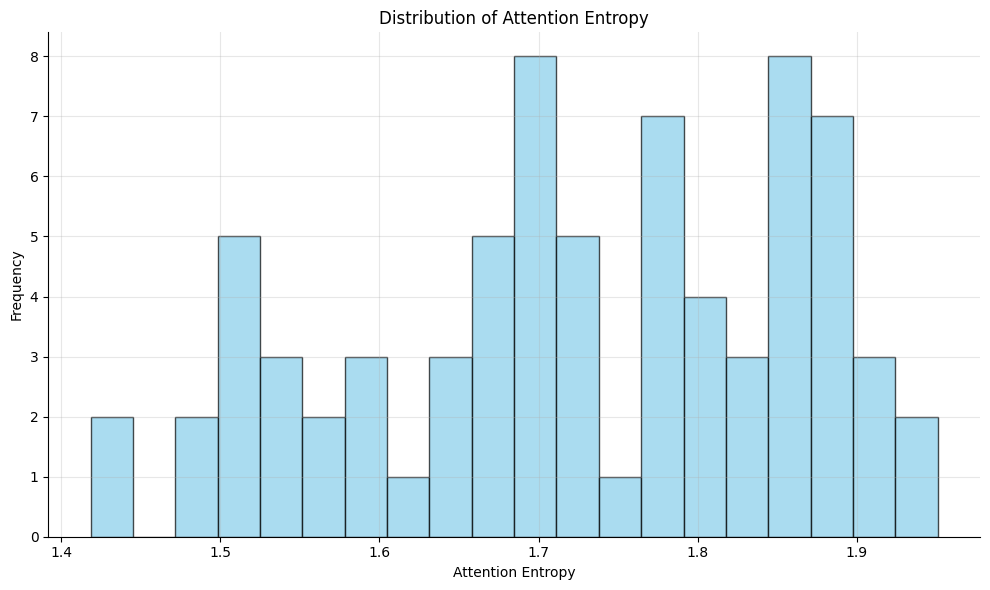

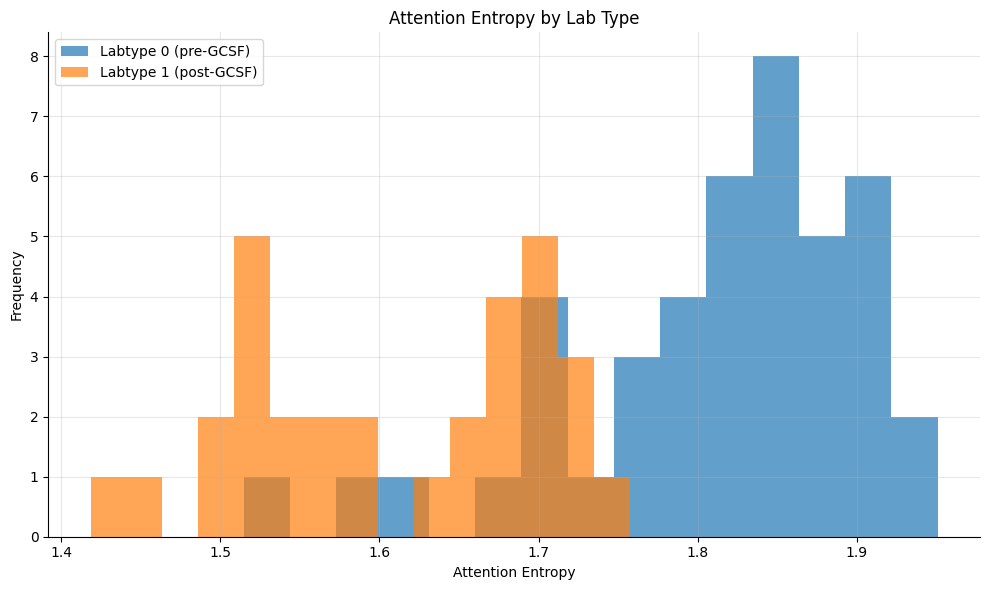

In [278]:

def attention_entropy(attention_weights):
    """Calculate entropy of attention weights. Lower entropy = more focused attention."""
    
    epsilon = 1e-10
    attention_weights = attention_weights + epsilon
    entropy = -np.sum(attention_weights * np.log(attention_weights), axis=1)
    return entropy


att_test = att_extractor.predict([X_te_f, X_te_lab])
entropies = attention_entropy(att_test)

print(f"Attention Entropy Statistics:")
print(f"Mean entropy: {np.mean(entropies):.4f}")
print(f"Std entropy: {np.std(entropies):.4f}")
print(f"Min entropy: {np.min(entropies):.4f}")
print(f"Max entropy: {np.max(entropies):.4f}")


entropy_df = pd.DataFrame({
    'entropy': entropies,
    'labtype': X_test['labtype'].values
})

print(f"\nEntropy by lab type:")
print(entropy_df.groupby('labtype')['entropy'].agg(['mean', 'std']))

# Plot 1: Overall entropy distribution
plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
plt.xlabel('Attention Entropy')
plt.ylabel('Frequency')
plt.title('Distribution of Attention Entropy')
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_entropy_distribution.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_entropy_distribution.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Entropy distribution by lab type
plt.figure(figsize=(10, 6))
for lt in [0, 1]:
    subset_entropies = entropy_df[entropy_df['labtype'] == lt]['entropy']
    plt.hist(subset_entropies, bins=15, alpha=0.7, 
             label=f"Labtype {lt} ({'pre' if lt==0 else 'post'}-GCSF)")
plt.xlabel('Attention Entropy')
plt.ylabel('Frequency')
plt.title('Attention Entropy by Lab Type')
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_entropy_by_labtype.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_entropy_by_labtype.pdf', dpi=300, bbox_inches='tight')
plt.show()

Spearman rank correlation between RF importance and attention: 0.4462
P-value: 0.1098

Overlap in top 10 features: 8/10 (80.0%)


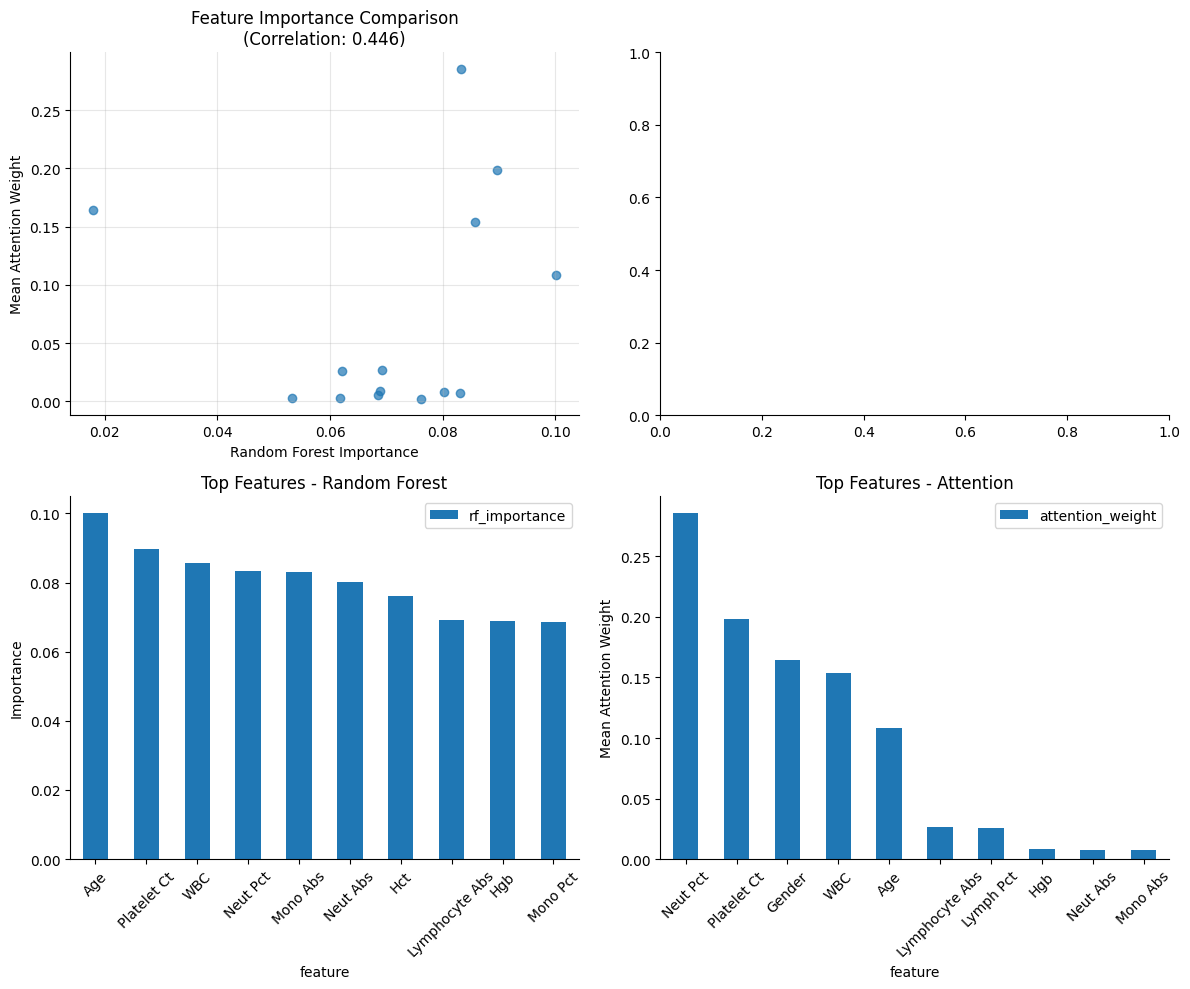

In [220]:
# 2. Compare Attention with Traditional Feature Importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Train a Random Forest for comparison
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.drop(columns=['labtype']), y_train)

# Get traditional feature importance
rf_importance = pd.Series(rf.feature_importances_, 
                         index=X_train.drop(columns=['labtype']).columns)

# Get mean attention weights
mean_attention = pd.DataFrame(att_test, 
                             columns=X_train.drop(columns=['labtype']).columns).mean()

# Compare the rankings
comparison_df = pd.DataFrame({
    'feature': rf_importance.index,
    'rf_importance': rf_importance.values,
    'attention_weight': mean_attention.values
})

# Calculate correlation between rankings
from scipy.stats import spearmanr
rank_correlation, p_value = spearmanr(comparison_df['rf_importance'], 
                                     comparison_df['attention_weight'])

print(f"Spearman rank correlation between RF importance and attention: {rank_correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Plot comparison
plt.figure(figsize=(12, 10))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(comparison_df['rf_importance'], comparison_df['attention_weight'], alpha=0.7)
plt.xlabel('Random Forest Importance')
plt.ylabel('Mean Attention Weight')
plt.title(f'Feature Importance Comparison\n(Correlation: {rank_correlation:.3f})')
plt.grid(alpha=0.3)

# Top features comparison
plt.subplot(2, 2, 2)
top_n = 10
top_rf = comparison_df.nlargest(top_n, 'rf_importance')['feature'].tolist()
top_att = comparison_df.nlargest(top_n, 'attention_weight')['feature'].tolist()

overlap = len(set(top_rf) & set(top_att))
print(f"\nOverlap in top {top_n} features: {overlap}/{top_n} ({overlap/top_n*100:.1f}%)")

# Bar plots for top features
plt.subplot(2, 2, 3)
comparison_df.nlargest(top_n, 'rf_importance').plot(x='feature', y='rf_importance', 
                                                   kind='bar', ax=plt.gca())
plt.title('Top Features - Random Forest')
plt.xticks(rotation=45)
plt.ylabel('Importance')

plt.subplot(2, 2, 4)
comparison_df.nlargest(top_n, 'attention_weight').plot(x='feature', y='attention_weight', 
                                                      kind='bar', ax=plt.gca())
plt.title('Top Features - Attention')
plt.xticks(rotation=45)
plt.ylabel('Mean Attention Weight')

plt.tight_layout()
sns.despine()
plt.show()

In [221]:
# 3. Ablation Study - Model without Attention
print("Building baseline model without attention for comparison...")

# Build a model without attention mechanism
feat_in_baseline = layers.Input(shape=(n_feat,), name='features')
lab_in_baseline = layers.Input(shape=(1,), name='labtype')

# Simply concatenate features and labtype (no attention)
combined = layers.Concatenate()([feat_in_baseline, lab_in_baseline])

# Same architecture as attention model but without attention
x = layers.Dense(264, activation='leaky_relu', 
                 kernel_initializer='normal',
                 kernel_regularizer=regularizers.l2(0.01))(combined)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='leaky_relu', 
                 kernel_initializer='normal', 
                 kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='leaky_relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='relu')(x)
x = layers.Dropout(0.2)(x)
logit_baseline = layers.Dense(1, activation='sigmoid')(x)

baseline_model = models.Model(inputs=[feat_in_baseline, lab_in_baseline], 
                             outputs=logit_baseline, name='CBC_Baseline_CLF')

baseline_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics=[tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.BinaryAccuracy(name='acc')])

print("Training baseline model...")
baseline_hist = baseline_model.fit([X_tr_f, X_tr_lab], y_tr_over,
                                 validation_data=([X_v_f, X_v_lab], y_val),
                                 epochs=100, batch_size=128, verbose=0)

# Evaluate both models
print("\n" + "="*50)
print("MODEL COMPARISON - Attention vs Baseline")
print("="*50)

# Attention model performance
att_y_prob = model.predict([X_te_f, X_te_lab], verbose=0).ravel()
att_y_pred = (att_y_prob >= 0.5).astype(int)
att_auc = roc_auc_score(y_test, att_y_prob)
att_acc = accuracy_score(y_test, att_y_pred)
att_f1 = f1_score(y_test, att_y_pred)

# Baseline model performance
base_y_prob = baseline_model.predict([X_te_f, X_te_lab], verbose=0).ravel()
base_y_pred = (base_y_prob >= 0.5).astype(int)
base_auc = roc_auc_score(y_test, base_y_prob)
base_acc = accuracy_score(y_test, base_y_pred)
base_f1 = f1_score(y_test, base_y_pred)

results_comparison = pd.DataFrame({
    'Model': ['Attention Model', 'Baseline Model', 'Improvement'],
    'AUC': [att_auc, base_auc, att_auc - base_auc],
    'Accuracy': [att_acc, base_acc, att_acc - base_acc],
    'F1-Score': [att_f1, base_f1, att_f1 - base_f1]
})

print(results_comparison.round(4))

# Statistical significance test
from scipy.stats import ttest_rel
try:
    # Test if attention model predictions are significantly different
    t_stat, p_val = ttest_rel(att_y_prob, base_y_prob)
    print(f"\nPaired t-test for prediction differences:")
    print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")
    if p_val < 0.05:
        print("The attention model performs significantly differently (p < 0.05)")
    else:
        print("No significant difference between models (p >= 0.05)")
except Exception as e:
    print(f"Could not perform statistical test: {e}")

Building baseline model without attention for comparison...
Training baseline model...

MODEL COMPARISON - Attention vs Baseline
             Model     AUC  Accuracy  F1-Score
0  Attention Model  0.8853    0.8108    0.8000
1   Baseline Model  0.8729    0.8108    0.8158
2      Improvement  0.0124    0.0000   -0.0158

Paired t-test for prediction differences:
T-statistic: -0.9142, P-value: 0.3636
No significant difference between models (p >= 0.05)


Analyzing attention patterns across different sample types...
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Attention analysis by prediction outcome:
Correct Positive: 28 samples
Correct Negative: 32 samples
False Positive: 5 samples
False Negative: 9 samples


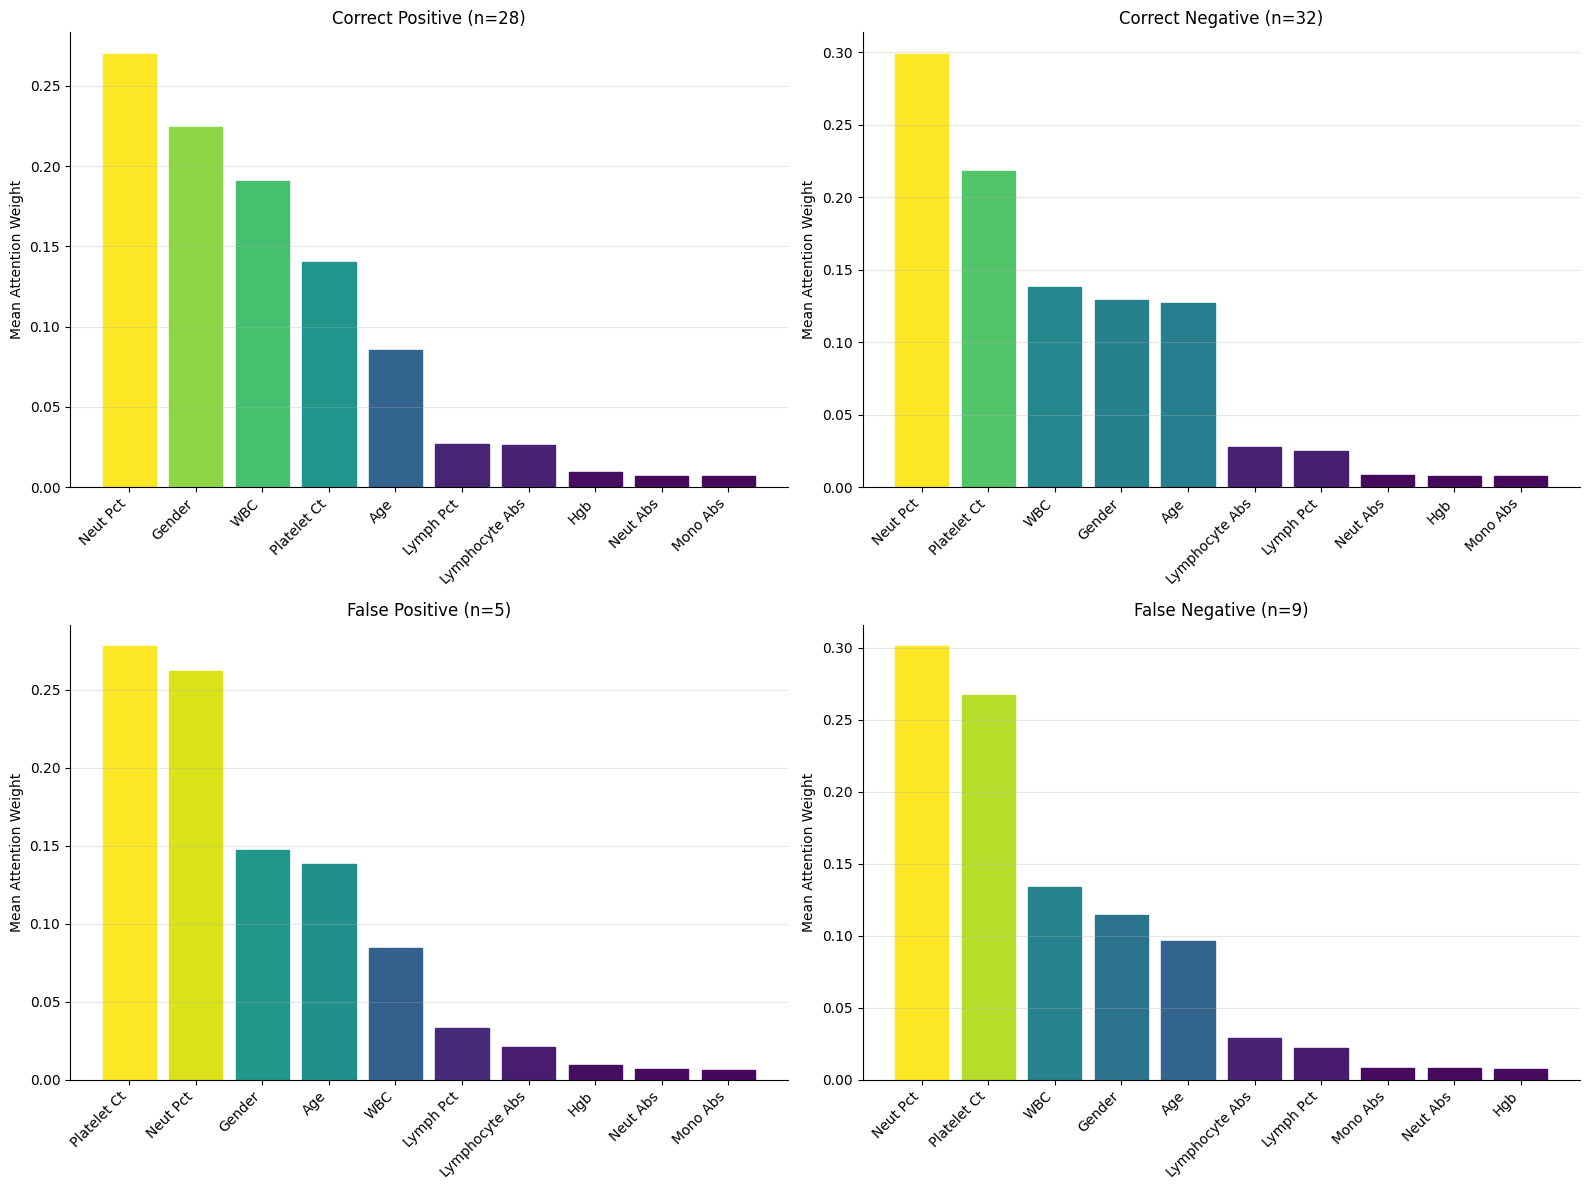


Attention Consistency Analysis:
Mean attention standard deviation across samples: 0.0373
Most consistent feature: Hct
Most variable feature: Platelet Ct


In [222]:
# 4. Attention Pattern Analysis Across Samples
print("Analyzing attention patterns across different sample types...")

# Get predictions and attention for analysis
att_weights_full = att_extractor.predict([X_te_f, X_te_lab])
y_prob_full = model.predict([X_te_f, X_te_lab]).ravel()
y_pred_full = (y_prob_full >= 0.5).astype(int)

# Create analysis dataframe
attention_analysis = pd.DataFrame(att_weights_full, 
                                 columns=X_train.drop(columns=['labtype']).columns)
attention_analysis['labtype'] = X_test['labtype'].values
attention_analysis['true_label'] = y_test
attention_analysis['predicted_label'] = y_pred_full
attention_analysis['prediction_confidence'] = y_prob_full
attention_analysis['correct_prediction'] = (y_test == y_pred_full)

# Analyze attention patterns for different prediction outcomes
print("\nAttention analysis by prediction outcome:")

outcomes = {
    'Correct Positive': (attention_analysis['true_label'] == 1) & 
                       (attention_analysis['correct_prediction'] == True),
    'Correct Negative': (attention_analysis['true_label'] == 0) & 
                       (attention_analysis['correct_prediction'] == True),
    'False Positive': (attention_analysis['true_label'] == 0) & 
                     (attention_analysis['predicted_label'] == 1),
    'False Negative': (attention_analysis['true_label'] == 1) & 
                     (attention_analysis['predicted_label'] == 0)
}

feature_cols = X_train.drop(columns=['labtype']).columns

plt.figure(figsize=(16, 12))

for i, (outcome_name, mask) in enumerate(outcomes.items()):
    if mask.sum() > 0:  # Only plot if we have samples
        plt.subplot(2, 2, i+1)
        
        # Get mean attention for this outcome
        outcome_attention = attention_analysis[mask][feature_cols].mean()
        outcome_attention = outcome_attention.sort_values(ascending=False)
        
        # Plot top 10 features
        top_features = outcome_attention.head(10)
        bars = plt.bar(range(len(top_features)), top_features.values)
        plt.title(f'{outcome_name} (n={mask.sum()})')
        plt.ylabel('Mean Attention Weight')
        plt.xticks(range(len(top_features)), top_features.index, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        
        # Color code bars
        colors = plt.cm.viridis(top_features.values / top_features.max())
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        print(f"{outcome_name}: {mask.sum()} samples")

plt.tight_layout()
sns.despine()
plt.show()

# Attention consistency analysis
print(f"\nAttention Consistency Analysis:")
print(f"Mean attention standard deviation across samples: {np.mean(np.std(att_weights_full, axis=0)):.4f}")
print(f"Most consistent feature: {feature_cols[np.argmin(np.std(att_weights_full, axis=0))]}")
print(f"Most variable feature: {feature_cols[np.argmax(np.std(att_weights_full, axis=0))]}")

Analyzing domain-specific attention patterns...
Jensen-Shannon divergence between lab types: 0.2742
(Higher values indicate more different attention patterns)


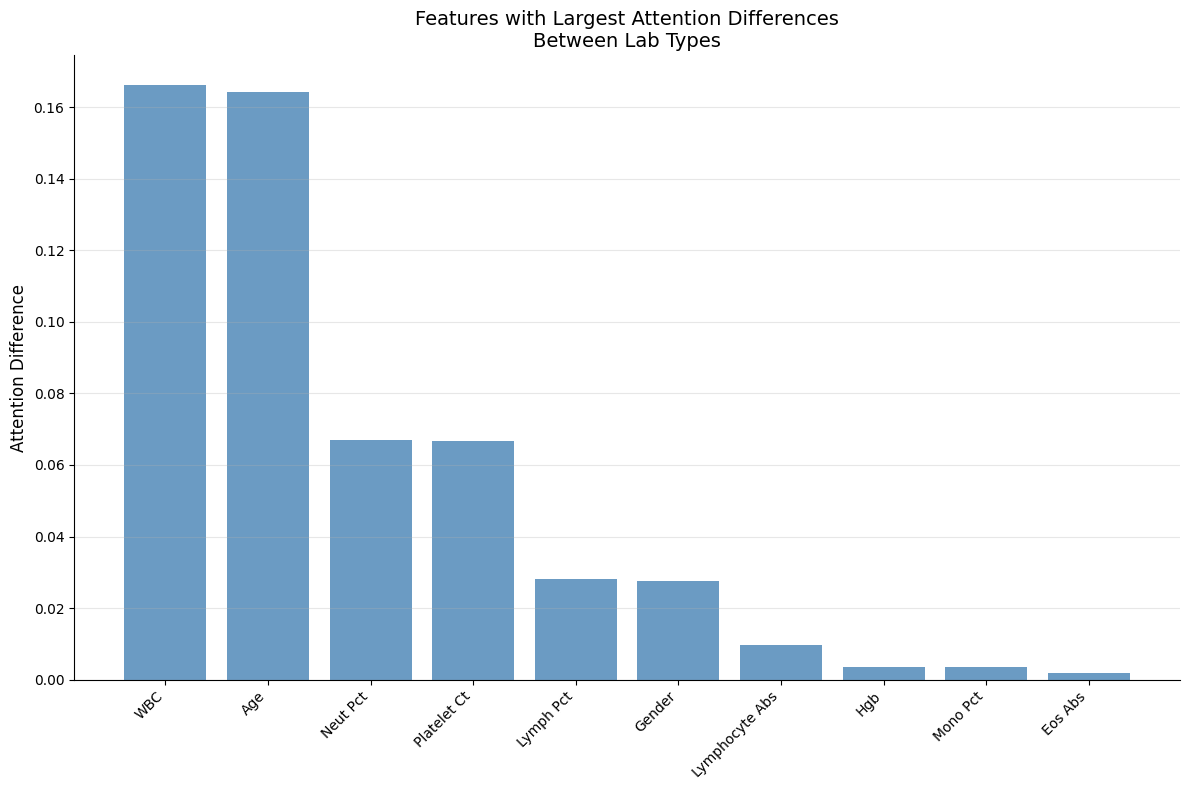

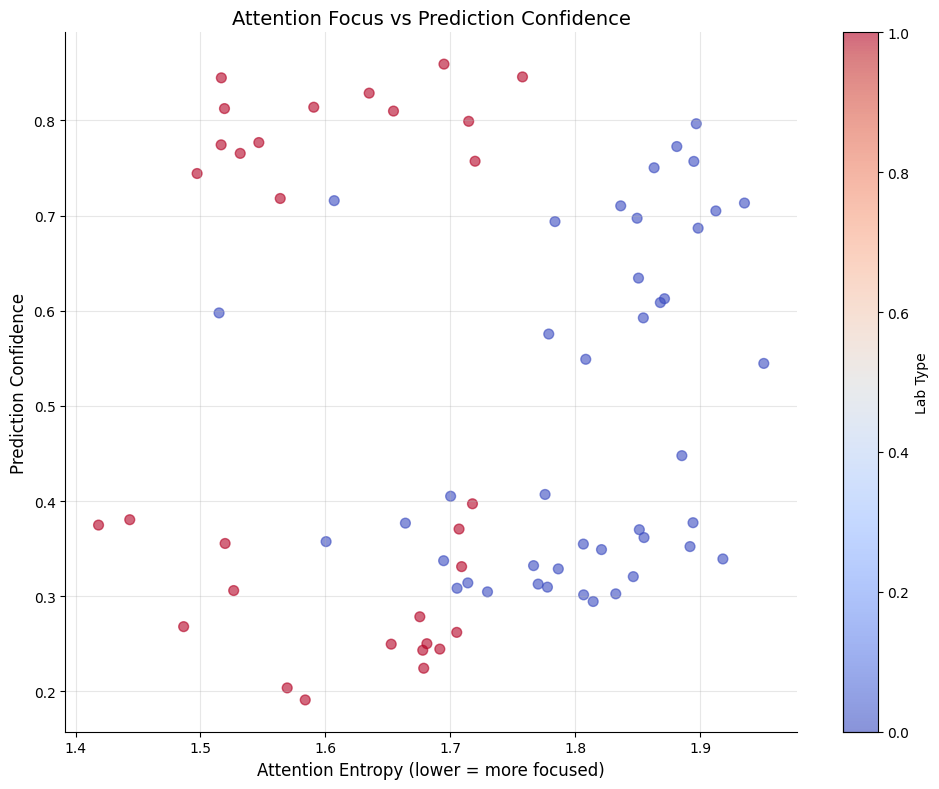

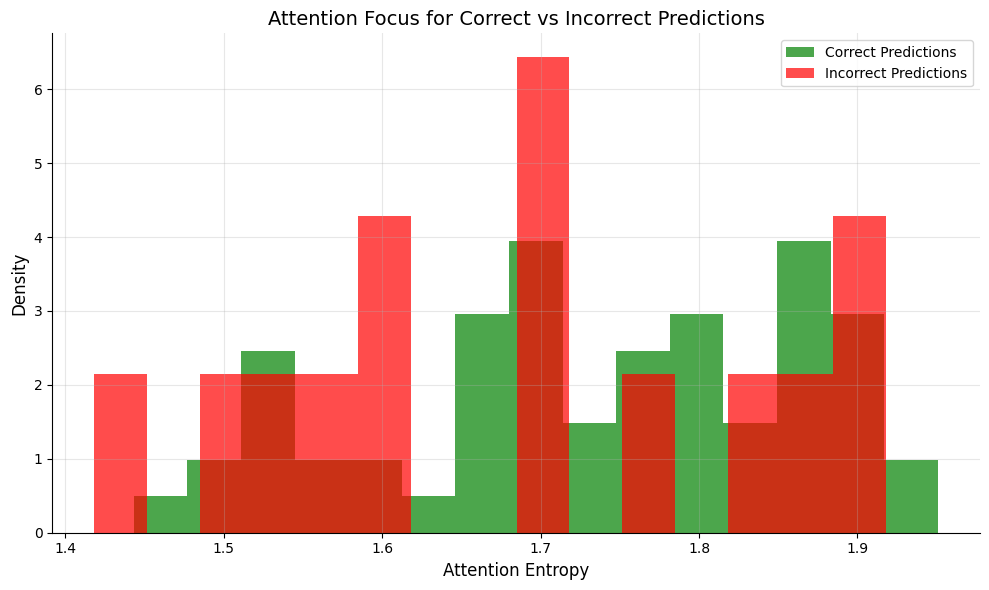

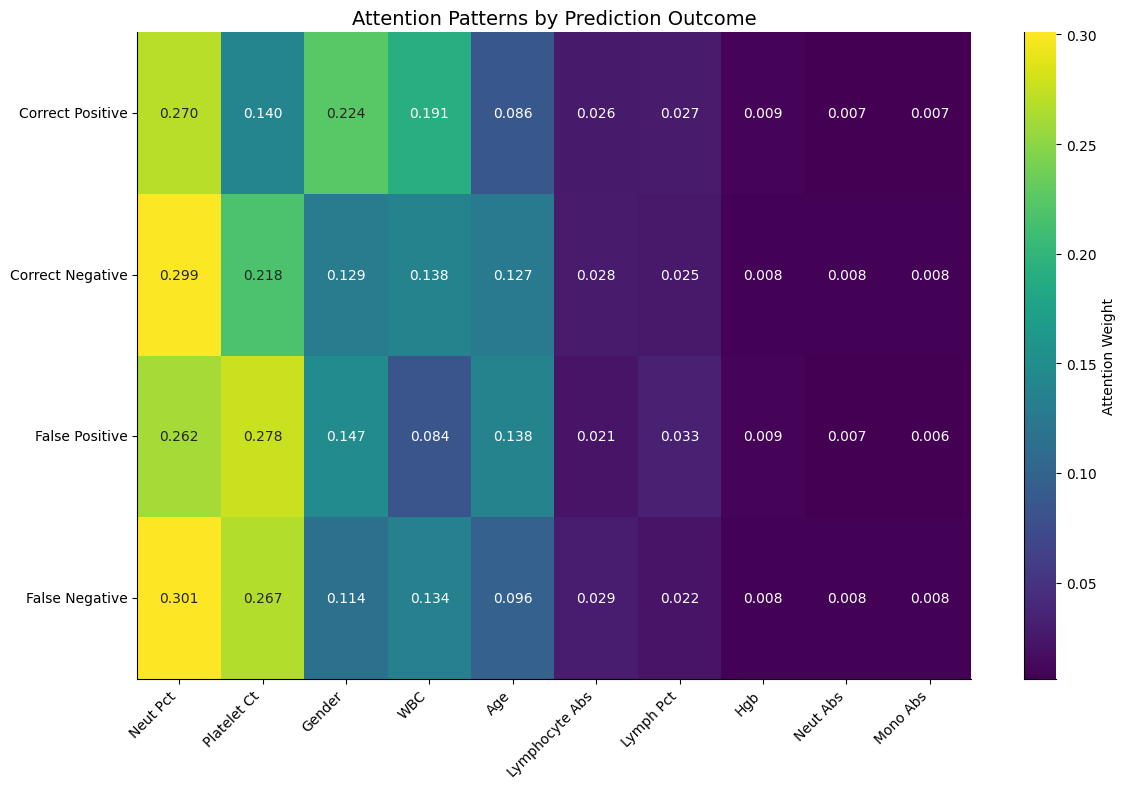


Attention Quality Summary:
- Mean attention entropy: 1.7252
- Attention entropy for correct predictions: 1.7338
- Attention entropy for incorrect predictions: 1.6882
- Domain divergence (lab types): 0.2742

Top 5 features with different attention between lab types:
1. WBC: Lab0=0.0842, Lab1=0.2504, Diff=0.1662
2. Age: Lab0=0.1772, Lab1=0.0128, Diff=0.1644
3. Neut Pct: Lab0=0.2576, Lab1=0.3245, Diff=0.0669
4. Platelet Ct: Lab0=0.2264, Lab1=0.1598, Diff=0.0666
5. Lymph Pct: Lab0=0.0377, Lab1=0.0097, Diff=0.0281

Correlation between attention entropy and prediction confidence: 0.0190 (p=0.8726)

ATTENTION MECHANISM EVALUATION COMPLETE

Attention Quality Summary:
- Mean attention entropy: 1.7252
- Attention entropy for correct predictions: 1.7338
- Attention entropy for incorrect predictions: 1.6882
- Domain divergence (lab types): 0.2742

Top 5 features with different attention between lab types:
1. WBC: Lab0=0.0842, Lab1=0.2504, Diff=0.1662
2. Age: Lab0=0.1772, Lab1=0.0128, Diff=0.1644


In [279]:
# 5. Domain-Specific Analysis & Attention Quality Metrics
print("Analyzing domain-specific attention patterns...")

# Calculate attention diversity between lab types
labtype_0_attention = attention_analysis[attention_analysis['labtype'] == 0][feature_cols].mean()
labtype_1_attention = attention_analysis[attention_analysis['labtype'] == 1][feature_cols].mean()

# Calculate divergence between lab types
from scipy.spatial.distance import jensenshannon
attention_divergence = jensenshannon(labtype_0_attention.values, labtype_1_attention.values)
print(f"Jensen-Shannon divergence between lab types: {attention_divergence:.4f}")
print(f"(Higher values indicate more different attention patterns)")

# Feature-wise attention difference
attention_diff = np.abs(labtype_0_attention - labtype_1_attention)
attention_diff = attention_diff.sort_values(ascending=False)

# Calculate sample-wise attention entropy for subsequent plots
sample_entropy = attention_entropy(att_weights_full)
correct_entropy = sample_entropy[attention_analysis['correct_prediction']]
incorrect_entropy = sample_entropy[~attention_analysis['correct_prediction']]

# Plot 1: Attention difference between lab types
plt.figure(figsize=(12, 8))
top_diff_features = attention_diff.head(10)
bars = plt.bar(range(len(top_diff_features)), top_diff_features.values, color='steelblue', alpha=0.8)
plt.title('Features with Largest Attention Differences\nBetween Lab Types', fontsize=14)
plt.ylabel('Attention Difference', fontsize=12)
plt.xticks(range(len(top_diff_features)), top_diff_features.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

# Plot 2: Attention vs Prediction Confidence
plt.figure(figsize=(10, 8))
scatter = plt.scatter(sample_entropy, attention_analysis['prediction_confidence'], 
           c=attention_analysis['labtype'], alpha=0.6, cmap='coolwarm', s=50)
plt.xlabel('Attention Entropy (lower = more focused)', fontsize=12)
plt.ylabel('Prediction Confidence', fontsize=12)
plt.title('Attention Focus vs Prediction Confidence', fontsize=14)
plt.colorbar(scatter, label='Lab Type')
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_vs_confidence.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_vs_confidence.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 3: Attention quality by correct/incorrect predictions
plt.figure(figsize=(10, 6))
plt.hist(correct_entropy, bins=15, alpha=0.7, label='Correct Predictions', density=True, color='green')
plt.hist(incorrect_entropy, bins=15, alpha=0.7, label='Incorrect Predictions', density=True, color='red')
plt.xlabel('Attention Entropy', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Attention Focus for Correct vs Incorrect Predictions', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_correct_vs_incorrect.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_correct_vs_incorrect.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Plot 4: Top attended features heatmap
plt.figure(figsize=(12, 8))
# Get top 10 most attended features overall
top_features = attention_analysis[feature_cols].mean().nlargest(10)
heatmap_data = []
for outcome_name, mask in outcomes.items():
    if mask.sum() > 0:
        outcome_attention = attention_analysis[mask][top_features.index].mean()
        heatmap_data.append(outcome_attention.values)

if heatmap_data:
    heatmap_df = pd.DataFrame(heatmap_data, 
                             index=[name for name, mask in outcomes.items() if mask.sum() > 0],
                             columns=top_features.index)
    sns.heatmap(heatmap_df, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Attention Weight'})
    plt.title('Attention Patterns by Prediction Outcome', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

sns.despine()
plt.tight_layout()
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_heatmap.png', dpi=300, bbox_inches='tight')
plt.savefig(here() / config.plots / 'attention' / 'cbc_attention_heatmap.pdf', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

# Summary statistics
print(f"\nAttention Quality Summary:")
print(f"- Mean attention entropy: {np.mean(sample_entropy):.4f}")
print(f"- Attention entropy for correct predictions: {np.mean(correct_entropy):.4f}")
print(f"- Attention entropy for incorrect predictions: {np.mean(incorrect_entropy):.4f}")
print(f"- Domain divergence (lab types): {attention_divergence:.4f}")

# Top differentiating features between lab types
print(f"\nTop 5 features with different attention between lab types:")
for i, (feature, diff) in enumerate(attention_diff.head(5).items()):
    lab0_att = labtype_0_attention[feature]
    lab1_att = labtype_1_attention[feature]
    print(f"{i+1}. {feature}: Lab0={lab0_att:.4f}, Lab1={lab1_att:.4f}, Diff={diff:.4f}")

# Correlation between attention entropy and prediction confidence
from scipy.stats import pearsonr
entropy_conf_corr, p_val = pearsonr(sample_entropy, attention_analysis['prediction_confidence'])
print(f"\nCorrelation between attention entropy and prediction confidence: {entropy_conf_corr:.4f} (p={p_val:.4f})")

print(f"\n" + "="*60)
print("ATTENTION MECHANISM EVALUATION COMPLETE")
print("="*60)

# Summary statistics
print(f"\nAttention Quality Summary:")
print(f"- Mean attention entropy: {np.mean(sample_entropy):.4f}")
print(f"- Attention entropy for correct predictions: {np.mean(correct_entropy):.4f}")
print(f"- Attention entropy for incorrect predictions: {np.mean(incorrect_entropy):.4f}")
print(f"- Domain divergence (lab types): {attention_divergence:.4f}")

# Top differentiating features between lab types
print(f"\nTop 5 features with different attention between lab types:")
for i, (feature, diff) in enumerate(attention_diff.head(5).items()):
    lab0_att = labtype_0_attention[feature]
    lab1_att = labtype_1_attention[feature]
    print(f"{i+1}. {feature}: Lab0={lab0_att:.4f}, Lab1={lab1_att:.4f}, Diff={diff:.4f}")

# Correlation between attention entropy and prediction confidence
from scipy.stats import pearsonr
entropy_conf_corr, p_val = pearsonr(sample_entropy, attention_analysis['prediction_confidence'])
print(f"\nCorrelation between attention entropy and prediction confidence: {entropy_conf_corr:.4f} (p={p_val:.4f})")

print(f"\n" + "="*60)
print("ATTENTION MECHANISM EVALUATION COMPLETE")
print("="*60)